
# Lab 6 — SVM & XGBoost




In [ ]:

# === Imports & Settings ===
import os, re, glob, warnings, unicodedata
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

# xgboost install if missing
try:
    from xgboost import XGBClassifier
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xgboost"])
    from xgboost import XGBClassifier

from IPython.display import display

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.dpi'] = 120

print('Versions -> numpy', np.__version__, '| pandas', pd.__version__)


Versions -> numpy 2.0.2 | pandas 2.2.2


## 1) Загрузка данных

In [ ]:

# Colab-friendly upload
fname = None
try:
    from google.colab import files  # type: ignore
    print("Upload 'Global finance data.csv' (или аналогичный)")
    uploaded = files.upload()
    if uploaded:
        fname = list(uploaded.keys())[0]
except Exception:
    print("files.upload() недоступен — ищем файл локально.")

if fname is None:
    patterns = [r".*global.*finance.*\.csv$", r".*finance.*global.*\.csv$"]
    candidates = []
    for path in glob.glob("*.csv") + glob.glob("/content/*.csv") + glob.glob("/mnt/data/*.csv"):
        name = os.path.basename(path).lower()
        for p in patterns:
            if re.match(p, name):
                candidates.append(path); break
    fname = candidates[0] if candidates else "Global finance data.csv"

def robust_read_csv(path):
    for enc in ("utf-8", "cp1251", "latin1"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    return pd.read_csv(path)

df = robust_read_csv(fname)
print("Loaded:", fname, "| shape:", df.shape)
display(df.head(5))
display(df.info())
display(df.describe(include='all').transpose().head(25))


Upload 'Global finance data.csv' (или аналогичный)


Saving Global finance data.csv to Global finance data.csv
Loaded: Global finance data.csv | shape: (39, 26)


,Country,Date,Stock_Index,Index_Value,Daily_Change_Percent,Market_Cap_Trillion_USD,GDP_Growth_Rate_Percent,Inflation_Rate_Percent,Interest_Rate_Percent,Unemployment_Rate_Percent,...,Commodity_Index,Oil_Price_USD_Barrel,Gold_Price_USD_Ounce,Bond_Yield_10Y_Percent,Credit_Rating,Political_Risk_Score,Banking_Sector_Health,Real_Estate_Index,Export_Growth_Percent,Import_Growth_Percent
0,United States,2024-08-15,S&P_500,5437.2,0.34,51.2,2.8,2.9,5.50,3.7,...,1.12,77.85,2487.5,4.25,AAA,8.1,Strong,145.6,3.2,2.8
1,China,2024-08-15,Shanghai_Composite,2891.6,-0.82,12.4,5.2,0.8,3.10,5.2,...,0.98,77.85,2487.5,2.15,A+,6.7,Moderate,98.7,8.9,6.1
2,Japan,2024-08-15,Nikkei_225,36789.1,1.24,6.8,0.9,2.8,-0.10,2.4,...,1.05,77.85,2487.5,0.89,A+,8.4,Strong,89.3,5.1,4.7
3,Germany,2024-08-15,DAX,18234.5,0.67,2.9,0.3,2.2,4.50,3.1,...,1.08,77.85,2487.5,2.31,AAA,8.7,Strong,112.4,2.1,1.8
4,United Kingdom,2024-08-15,FTSE_100,8156.3,-0.15,3.1,1.1,2.0,5.25,4.2,...,1.06,77.85,2487.5,3.89,AA,7.9,Moderate,97.8,0.9,1.2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              39 non-null     object 
 1   Date                                 39 non-null     object 
 2   Stock_Index                          39 non-null     object 
 3   Index_Value                          39 non-null     float64
 4   Daily_Change_Percent                 39 non-null     float64
 5   Market_Cap_Trillion_USD              39 non-null     float64
 6   GDP_Growth_Rate_Percent              39 non-null     float64
 7   Inflation_Rate_Percent               39 non-null     float64
 8   Interest_Rate_Percent                39 non-null     float64
 9   Unemployment_Rate_Percent            39 non-null     float64
 10  Currency_Code                        39 non-null     object 
 11  Exchange_Rate_USD                 

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Country,39,39,United States,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,39,1,2024-08-15,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stock_Index,39,39,S&P_500,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Index_Value,39.0,NaN,NaN,NaN,59964.774359,249537.018541,889.3,2711.8,8156.3,23012.25,1567890.2
Daily_Change_Percent,39.0,NaN,NaN,NaN,0.654103,0.834672,-1.23,0.31,0.67,0.89,3.45
Market_Cap_Trillion_USD,39.0,NaN,NaN,NaN,2.912821,8.260615,0.03,0.4,0.7,2.45,51.2
GDP_Growth_Rate_Percent,39.0,NaN,NaN,NaN,2.415385,1.874558,-1.9,1.15,2.4,3.15,6.8
Inflation_Rate_Percent,39.0,NaN,NaN,NaN,11.023077,34.828629,-0.4,1.95,2.8,4.3,211.4
Interest_Rate_Percent,39.0,NaN,NaN,NaN,10.64359,21.866714,-0.1,4.05,4.75,6.5,133.0
Unemployment_Rate_Percent,39.0,NaN,NaN,NaN,5.887179,4.636138,1.2,3.3,5.1,7.3,28.7


## 2) Поиск/конструирование целевой переменной

In [ ]:

def normalize(s):
    if s is None: return ""
    s = str(s)
    s = unicodedata.normalize('NFKD', s)
    s = s.encode('ascii', 'ignore').decode('ascii')
    s = s.lower()
    s = re.sub(r"[^a-z0-9]+", "", s)
    return s

candidate_label_keywords = [
    "bankingsectorhealth","bankinghealth","banking","sectorhealth",
    "category","class","label","segment","group","cluster",
    "rating","creditrating"
]

label_col = None
for c in df.columns:
    cn = normalize(c)
    if df[c].dtype == 'object' or df[c].dtype.name == 'category':
        nunq = df[c].nunique(dropna=True)
        if 2 <= nunq <= 10 and any(kw in cn for kw in candidate_label_keywords):
            label_col = c
            break

if label_col is None:
    # fallback to any short-cardinality categorical column
    best_col, best_n = None, 999
    for c in df.columns:
        if df[c].dtype == 'object' or df[c].dtype.name == 'category':
            nunq = df[c].nunique(dropna=True)
            if 2 <= nunq <= 10 and nunq < best_n:
                best_col, best_n = c, nunq
    label_col = best_col

constructed = False
if label_col is None:
    # Construct label via tertiles of a preferred numeric column
    preferred_numeric = ["inflation","unemployment","debtgdp","governmentdebt","interest","gdpgrowth","gdp"]
    numeric_df = df.select_dtypes(include=[np.number])
    chosen_num = None
    for c in numeric_df.columns:
        if any(kw in normalize(c) for kw in preferred_numeric):
            chosen_num = c; break
    if chosen_num is None and len(numeric_df.columns) > 0:
        chosen_num = numeric_df.var().sort_values(ascending=False).index[0]

    q = pd.qcut(numeric_df[chosen_num].rank(method='first'), 3, labels=["Low","Medium","High"])
    df["_constructed_target"] = q.astype(str)
    label_col = "_constructed_target"
    constructed = True

print("Target column:", label_col, "| constructed:", constructed)
print("Class distribution:")
display(df[label_col].value_counts())


Target column: Banking_Sector_Health | constructed: False
Class distribution:


,count
Banking_Sector_Health,
Moderate,18
Strong,14
Weak,7


## 3) Предобработка и разбиение; **LabelEncoder** для y

In [ ]:

X = df.drop(columns=[label_col]).copy()
y_raw = df[label_col].astype(str).copy()

# Label encode y for XGBoost stability
le = LabelEncoder()
y = le.fit_transform(y_raw)  # integers 0..K-1
class_names = list(le.classes_)
n_classes = len(class_names)
print("Classes:", class_names, "| n_classes:", n_classes)

# Identify numeric & categorical features
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# Drop too-missing columns
def drop_too_missing(df_in, thresh=0.6):
    keep = [c for c in df_in.columns if df_in[c].notna().mean() >= (1 - thresh)]
    return df_in[keep], keep

X, kept = drop_too_missing(X, thresh=0.6)
numeric_cols = [c for c in numeric_cols if c in kept]
categorical_cols = [c for c in categorical_cols if c in kept]

# Simple fillna
for c in numeric_cols:
    X[c] = X[c].fillna(X[c].median())
for c in categorical_cols:
    X[c] = X[c].fillna("Unknown")

# Version-safe OneHotEncoder
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    except TypeError:
        # older sklearn
        return OneHotEncoder(handle_unknown='ignore', sparse=True)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), numeric_cols),  # with_mean=False to keep CSR compatible
        ("cat", make_ohe(), categorical_cols)
    ],
    sparse_threshold=0.0  # always return sparse when possible
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train/Test:", X_train.shape, X_test.shape)


Classes: ['Moderate', 'Strong', 'Weak'] | n_classes: 3
Train/Test: (29, 25) (10, 25)


## 4) Модели и обучение


In [ ]:

# SVM (RBF) — SVC поддерживает CSR-сжатые разреженные матрицы
svm_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42))
])

# XGBoost — классическая многоклассовая схема
xgb_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='multi:softprob',  # probabilities
        num_class=int(n_classes),
        random_state=42,
        eval_metric='mlogloss',
        tree_method='hist'  # faster on Colab
    ))
])

svm_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("SVM Accuracy:", acc_svm)
print("XGBoost Accuracy:", acc_xgb)

print("\nSVM report:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred_svm)))

print("XGBoost report:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred_xgb)))


SVM Accuracy: 0.5
XGBoost Accuracy: 0.9

SVM report:
              precision    recall  f1-score   support

    Moderate       0.50      1.00      0.67         5
      Strong       0.00      0.00      0.00         3
        Weak       0.00      0.00      0.00         2

    accuracy                           0.50        10
   macro avg       0.17      0.33      0.22        10
weighted avg       0.25      0.50      0.33        10

XGBoost report:
              precision    recall  f1-score   support

    Moderate       1.00      0.80      0.89         5
      Strong       1.00      1.00      1.00         3
        Weak       0.67      1.00      0.80         2

    accuracy                           0.90        10
   macro avg       0.89      0.93      0.90        10
weighted avg       0.93      0.90      0.90        10



## 5) Матрицы ошибок и сравнение точности

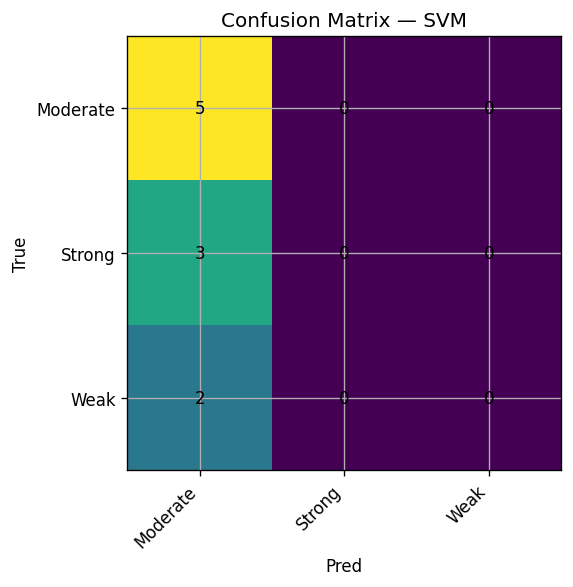

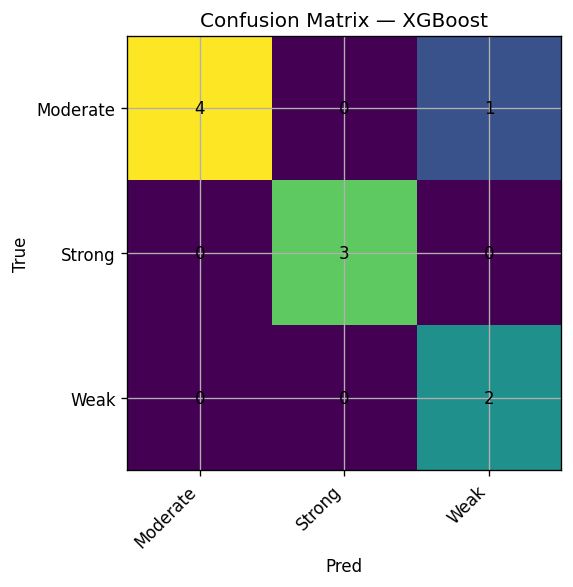

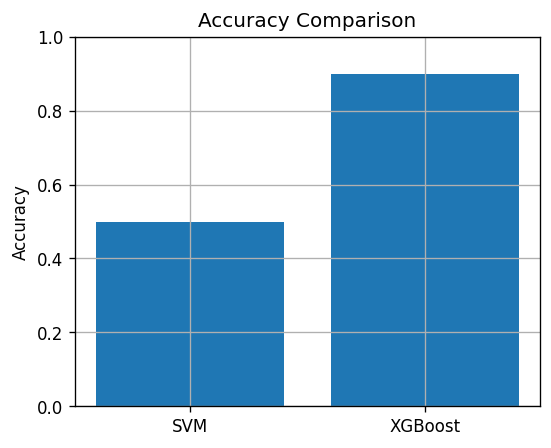

In [ ]:

def plot_confusion(cm, classes, title):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i,j]), ha='center', va='center')
    ax.set_ylabel('True'); ax.set_xlabel('Pred')
    plt.tight_layout(); plt.show()

classes = class_names
from sklearn.metrics import confusion_matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plot_confusion(cm_svm, classes, "Confusion Matrix — SVM")
plot_confusion(cm_xgb, classes, "Confusion Matrix — XGBoost")

plt.figure(figsize=(5,4))
plt.bar(["SVM","XGBoost"], [acc_svm, acc_xgb])
plt.ylim(0,1); plt.ylabel("Accuracy"); plt.title("Accuracy Comparison")
plt.show()







## 6) Важности признаков XGBoost

,feature,importance
109,cat::Credit_Rating=AAA,0.348964
15,num::Bond_Yield_10Y_Percent,0.173048
12,num::Commodity_Index,0.098602
16,num::Political_Risk_Score,0.089963
17,num::Real_Estate_Index,0.061901
10,num::Current_Account_Balance_Billion_USD,0.045743
5,num::Interest_Rate_Percent,0.043515
108,cat::Credit_Rating=AA,0.027242
2,num::Market_Cap_Trillion_USD,0.020314
6,num::Unemployment_Rate_Percent,0.014438


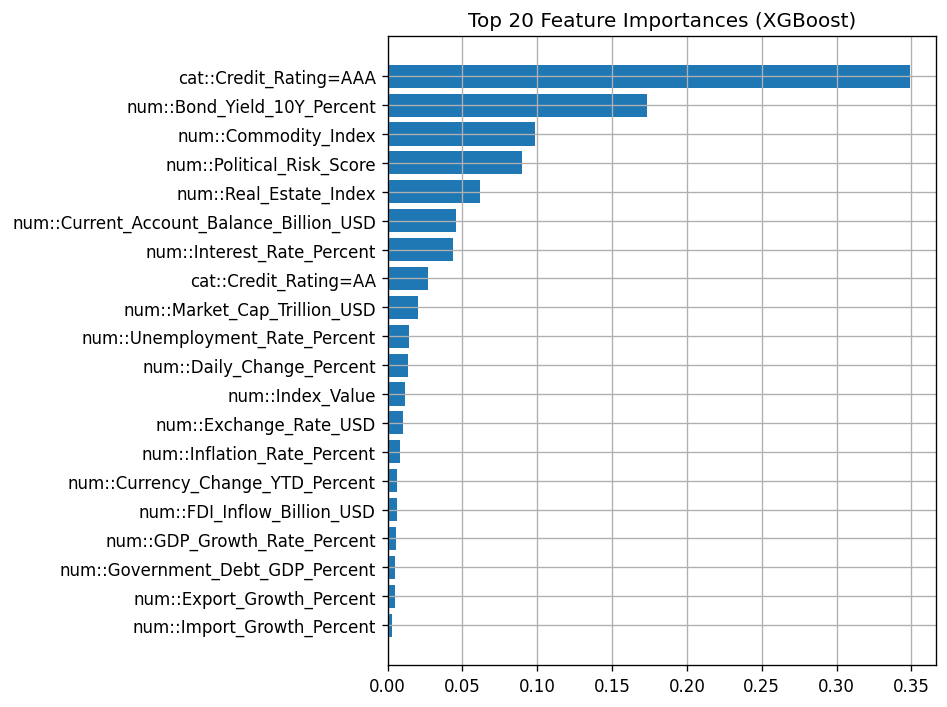

In [ ]:

# Извлечение важностей возможно только после разворачивания препроцессора.
try:
    xgb_model = xgb_clf.named_steps['model']
    prep = xgb_clf.named_steps['prep']

    # Список имён числовых и категориальных фич после трансформации
    num_names = [f"num::{c}" for c in (prep.transformers_[0][2] or [])]
    cat_names = []
    if len(prep.transformers_[1][2]) > 0:
        ohe = prep.named_transformers_['cat']
        cats = ohe.categories_
        for c, cat_values in zip(prep.transformers_[1][2], cats):
            cat_names += [f"cat::{c}={v}" for v in cat_values]
    feature_names = num_names + cat_names

    importances = xgb_model.feature_importances_
    import pandas as pd
    fi = pd.DataFrame({"feature": feature_names[:len(importances)], "importance": importances})
    fi = fi.sort_values("importance", ascending=False).head(20)
    display(fi)

    plt.figure(figsize=(8,6))
    plt.barh(fi["feature"][::-1], fi["importance"][::-1])
    plt.title("Top 20 Feature Importances (XGBoost)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Feature importances not available:", e)
